In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title 1. Import relevant modules
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import re
import string
import random
from sklearn.model_selection import train_test_split

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


In [4]:
#@title 2. Import Stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
en_stop_words = stopwords.words('english')
print(en_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

In [6]:
#@title 3. Set Top Level Variables
vocab_size = 5000  # Only consider the top 5K words
max_length = 50 # Maximum question (text) size in words
embedding_dim = 64

In [7]:
#@title 4. Import data
DF1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/counselchat-data.csv')

In [8]:
#@title 5. Task: Create new topics column by picking only first value out of multiple comma separated mental problems.
DF1['first_topics'] = DF1['topics'].apply(lambda n: str(n).split(',')[0])

In [88]:
#@title 6. Show first 5 examples from dataframe
DF1[['questionText', 'first_topics']].head()

,questionText,first_topics
0,My wife and mother are having tense disagreeme...,Family Conflict
1,"I'm planning to have baby, so I have to quit s...",Substance Abuse
2,"I have secrets in my mind, and I don't know wh...",Family Conflict
3,I am extremely possessive in my relationships ...,Behavioral Change
4,I had a head injury a few years ago and my min...,Anxiety


In [11]:
#@title 7. Number of Unique Topics 
DF1.first_topics.nunique()

33

In [12]:
#@title 8. Remove Stopwords
DF1['questionText_removed_stopwords'] = DF1['questionText'].apply(lambda x: ' '.join([word for word in str(x).split(' ') if word not in (en_stop_words)]))

In [13]:
#@title 9. Show first 5 examples from dataframe (new question text and topics columns)
DF1[['questionText_removed_stopwords', 'first_topics']].head()

,questionText_removed_stopwords,first_topics
0,"My wife mother tense disagreements. In past, t...",Family Conflict
1,"I'm planning baby, I quit smoking - hard. Some...",Substance Abuse
2,"I secrets mind, I know them. I want tell wife ...",Family Conflict
3,I extremely possessive relationships hurting f...,Behavioral Change
4,I head injury years ago mind races time. I tro...,Anxiety


In [14]:
#@title 10. Drop Null and create new DF -  ds
ds = DF1[['questionText_removed_stopwords', 'first_topics']].dropna()

In [15]:
#@title 11. Number of Unique Topics 
ds.first_topics.nunique()

33

### CREATE A TENSORFLOW DATA PIPELINE FOR TEXT PREPROCESSING & VECTORIZATION

In [17]:
#@title 1. Convert Topics From Strings to Integers
ds["first_topics"] = ds["first_topics"].astype('category')
ds["first_topics_id"] = ds["first_topics"].cat.codes
ds.head()

,questionText_removed_stopwords,first_topics,first_topics_id
0,"My wife mother tense disagreements. In past, t...",Family Conflict,12
1,"I'm planning baby, I quit smoking - hard. Some...",Substance Abuse,29
2,"I secrets mind, I know them. I want tell wife ...",Family Conflict,12
3,I extremely possessive relationships hurting f...,Behavioral Change,4
4,I head injury years ago mind races time. I tro...,Anxiety,3


In [18]:
#@title 2. Build a Dictionary for id to text category (topic) look-up:
id_to_topics = pd.Series(ds.first_topics.values,index=ds.first_topics_id).to_dict()
id_to_topics

{0: 'Addiction',
 1: "Alzheimer's",
 2: 'Anger Management',
 3: 'Anxiety',
 4: 'Behavioral Change',
 5: 'Career Counseling',
 6: 'Children & Adolescents',
 7: 'Counseling Fundamentals ',
 8: 'Depression',
 9: 'Diagnosis',
 10: 'Domestic Violence',
 11: 'Eating Disorders',
 12: 'Family Conflict',
 13: 'Grief and Loss',
 14: 'Human Sexuality',
 15: 'Intimacy',
 16: 'LGBTQ',
 17: 'Legal & Regulatory',
 18: 'Marriage',
 19: 'Military Issues ',
 20: 'Parenting',
 21: 'Professional Ethics',
 22: 'Relationship Dissolution ',
 23: 'Relationships',
 24: 'Self-esteem',
 25: 'Sleep Improvement',
 26: 'Social Relationships',
 27: 'Spirituality',
 28: 'Stress',
 29: 'Substance Abuse',
 30: 'Trauma',
 31: 'Workplace Relationships',
 32: 'nan'}

In [20]:
#@title 3. Store look-up dictionary as pickle file
import pickle
pkl_file = open("id_to_topics.pkl", "wb")
pickle.dump(id_to_topics, pkl_file)
pkl_file.close()

pkl_file = open("id_to_topics.pkl", "rb")
uploaded_id_to_topics = pickle.load(pkl_file)
print(uploaded_id_to_topics)

{12: 'Family Conflict', 29: 'Substance Abuse', 4: 'Behavioral Change', 3: 'Anxiety', 22: 'Relationship Dissolution ', 2: 'Anger Management', 25: 'Sleep Improvement', 21: 'Professional Ethics', 26: 'Social Relationships', 23: 'Relationships', 18: 'Marriage', 10: 'Domestic Violence', 14: 'Human Sexuality', 19: 'Military Issues ', 8: 'Depression', 13: 'Grief and Loss', 30: 'Trauma', 15: 'Intimacy', 31: 'Workplace Relationships', 16: 'LGBTQ', 27: 'Spirituality', 24: 'Self-esteem', 20: 'Parenting', 32: 'nan', 11: 'Eating Disorders', 17: 'Legal & Regulatory', 5: 'Career Counseling', 0: 'Addiction', 28: 'Stress', 9: 'Diagnosis', 1: "Alzheimer's", 7: 'Counseling Fundamentals ', 6: 'Children & Adolescents'}


In [23]:
#@title 4. Limit the number of samples to be used in testing the pipeline
# data_size= 1200 #instead of 431306 
data= ds #[:data_size]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482 entries, 0 to 1481
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   questionText_removed_stopwords  1482 non-null   object  
 1   first_topics                    1482 non-null   category
 2   first_topics_id                 1482 non-null   int8    
dtypes: category(1), int8(1), object(1)
memory usage: 27.4+ KB


In [22]:
data.shape

(1482, 3)

In [24]:
#@title 5. Split the Raw Dataset into Train and Test Datasets

#save features and targets from the 'data'
features, targets = data['questionText_removed_stopwords'], data['first_topics_id']

train_features, test_features, train_targets, test_targets = train_test_split(
        features, targets,
        train_size=0.8,
        test_size=0.2,
        random_state=40,
        shuffle = True
    )

In [26]:
#@title  6. Prepare TensorFlow Datasets from Pandas DF

#We convert the data stored in Pandas Data Frame into  a data stored in TensorFlow Data Set as below:

# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_features.values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_targets.values, tf.int64),

) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_features.values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_targets.values, tf.int64),

) 

# **USE KERAS TEXT VECTORIZATION LAYER**

# 7. PREPROCESS THE TEXT WITH THE KERAS `TEXTVECTORIZATION` LAYER



## 8.1. Define your own `custom_standardization` function
First, I define a function which will preprocess the given text.
The `custom_standardization` function will convert the given string to a standart form by transforming the input applying several updates:
* convert all characters to lowercase
* remove special symbols, extra spaces, html tags, digits, and puctuations
* remove stop words

In [27]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_string):
    """ Remove html line-break tags and handle punctuation """
    for each in en_stop_words:
      if each == 'not' or each == 'no' or each == 'never' : 
        input_string = input_string
      else:
        input_string = tf.strings.regex_replace(input_string, ' '+each+' ' , r" ")
    no_uppercased = tf.strings.lower(input_string, encoding='utf-8')
    no_punctuations = tf.strings.regex_replace(no_uppercased, f"([{string.punctuation}])", r" ")
    no_extra_space = tf.strings.regex_replace(no_punctuations, " +"," ")

    return no_extra_space

## 8.2. Configure the Keras `TextVectorization layer`

To preprocess the text, I will use the Keras `TextVectorization` layer. 

```python
tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None,
    output_mode="int",
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    **kwargs
)
```

The Keras `TextVectorization` layer processes each example in the dataset as follows:

1. Standardize each example (usually lowercasing + punctuation stripping)

2. Split each example into substrings (usually words)

3. Recombine substrings into tokens (usually ngrams)

4. Index tokens (associate a unique int value with each token)

5. Transform each example using this index, either into a vector of ints or a dense float vector.




Let's build our `TextVectorization` layer by providing:

1. The `custom_standardization()` function for the `standardize` method (callable).
2. The `vocab_size` as the `max_tokens` number: The `max_tokens` is the maximum size of the vocabulary that will be created from the dataset. If `None`, there is no cap on the size of the vocabulary. Note that this vocabulary contains 1 **OOV (Out Of Vocabulary)** token, so the effective number of tokens is (max_tokens - 1 - (1 if output_mode == "int" else 0)).
3. The `int` keyword as the `output_mode`: Optional specification for the **output** of the layer. Values can be 
* "**int**", 
* "**multi_hot**", 
* "**count**" or 
* "**tf_idf**", 

Configuring the layer as follows: 
* "**int**": Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1.

* "**multi_hot**": Outputs a single int array per batch, of either vocab_size or max_tokens size, containing 1s in all elements where the token mapped to that index exists at least once in the batch item. 

* "**count**": Like "multi_hot", but the int array contains a count of the number of times the token at that index appeared in the batch item. 

* "**tf_idf**": Like "multi_hot", but the TF-IDF algorithm is applied to find the value in each token slot. 

For "**int**" output, any shape of input and output is supported. 

For **all other output modes**, currently only **rank 1 inputs** (and rank 2 outputs after splitting) are supported. 


In [28]:

#@title Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size+2,
    output_mode="int",
    output_sequence_length=max_length,
)

vectorize_layer.adapt(ds['questionText_removed_stopwords'])
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

In [29]:
#@title Test Vectorization
input_string = "I'm in my early 20s. I’ve been married once, and he cheated on me. Ever since then, I've felt ugly no matter what. I'm engaged, and I still feel ugly. I don't like to take pictures of myself"
print("input:  ", input_string)
output_string= custom_standardization(input_string)
print("output: ", output_string.numpy().decode("utf-8"))


input:   I'm in my early 20s. I’ve been married once, and he cheated on me. Ever since then, I've felt ugly no matter what. I'm engaged, and I still feel ugly. I don't like to take pictures of myself
output:  i m early 20s i’ve married once cheated me ever since then i ve felt ugly no matter what i m engaged i still feel ugly i like take pictures myself


## 8.3. Adapt the Keras `TextVectorization` layer with the **training** data set, (not test data set!) 

In [30]:
#@title Adapt to trainset features and get vocabulary
vectorize_layer.adapt(train_features)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

In [31]:
#@title Print few samples

print("vocab has the ", len(vocab)," entries")
print("vocab has the following first 10 entries")
for word in range(10):
  print(word, " represents the word: ", vocab[word])

for X in train_features[:2]:
  print(" Given raw data: " )
  print(X)
  tokenized = vectorize_layer(tf.expand_dims(X, -1))
  print(" Tokenized and Transformed to a vector of integers: " )
  print (tokenized)
  print(" Text after Tokenized and Transformed: ")
  transformed = ""
  for each in tf.squeeze(tokenized):
    transformed= transformed+ " "+ vocab[each]
  print(transformed)

vocab has the  3266  entries
vocab has the following first 10 entries
0  represents the word:  
1  represents the word:  [UNK]
2  represents the word:  i
3  represents the word:  m
4  represents the word:  he
5  represents the word:  feel
6  represents the word:  like
7  represents the word:  it
8  represents the word:  me
9  represents the word:  my
 Given raw data: 
I early 20s I still live parents I can't afford live alone.

My mother says I live roof I follow rules. She trying control life. What I do?
 Tokenized and Transformed to a vector of integers: 
tf.Tensor(
[[  2 297 207   2  30 100  95   2  25  28 470 100 154   9 129  84   2 100
  881   2 727 880  19 149 301  31  46   2  39   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)
 Text after Tokenized and Transformed: 
 i early 20s i still live parents i can t afford live alone my mother says i live roof i follow rules she trying control life what i do             

## 8.4. Save & Upload TextVectorization layer

Due to the facts that adapting the Keras `TextVectorization` layer on a large text dataset takes considerable amount of time and porting the adapted layer to a different deployment environment is a high possibility, it is good to know how to save and load it.

How to save a Keras `TextVectorization` layer? 

[There are currently 2 ways of doing it](https://stackoverflow.com/questions/65103526/how-to-save-textvectorization-to-disk-in-tensorflow):
* save the Keras `TextVectorization` layer in a Keras Model
* save the Keras `TextVectorization` layer as a pickle file.

In this tutorial, I will use the first approach as it is native to the TF/Keras environment.



### 8.4.1. Create a temporary Keras `model` by adding the adapted Keras `TextVectorization` layer

In [86]:
#@title Create model.
vectorize_layer_model = tf.keras.models.Sequential()
vectorize_layer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorize_layer_model.add(vectorize_layer)
vectorize_layer_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


## 8.4.2. Save the temporary model including the adapted Keras `TextVectorization` layer

In [34]:
filepath = "vectorize_layer_model"

In [35]:
#@title Save model
vectorize_layer_model.save(filepath, save_format="tf")

INFO:tensorflow:Assets written to: vectorize_layer_model/assets


## 8.4.3. Load the `vectorize_layer_model` back to chek if saving is succesfull

In [36]:
#@title Load model
loaded_vectorize_layer_model = tf.keras.models.load_model(filepath)

### 8.4.4 Retrieve the **loaded** Keras `TextVectorization` layer

Here, you have 2 options:
* use the `loaded_model.predicted()` method to use the Keras `TextVectorization` layer, or
* get the Keras `TextVectorization` layer out of the `loaded_model` as below:



In [37]:
#@title Retrieve Model
loaded_vectorize_layer = loaded_vectorize_layer_model.layers[0]


### 8.4.5. Compare the original and loaded `TextVectorization` layers

In [38]:
loaded_vocab=loaded_vectorize_layer.get_vocabulary()
print("original vocab has the ", len(vocab)," entries")
print("loaded vocab has the   ", len(loaded_vocab)," entries")
print("loaded vocab has the following first 10 entries")
for word in range(10):
  print(word, " represents the word: ")
  print(vocab[word], " in original vocab")
  print(loaded_vocab[word], " in loaded vocab")
for X in train_features[:1]:
  print(" Given raw data: " )
  print(X)

  tokenized = vectorize_layer(tf.expand_dims(X, -1))
  print(" Tokenized and Transformed to a vector of integers by the original vectorize layer:" )
  print (tokenized)

  tokenized = loaded_vectorize_layer(tf.expand_dims(X, -1))
  print(" Tokenized and Transformed to a vector of integers by the loaded vectorize layer:" )
  print (tokenized)
  
  tokenized = loaded_vectorize_layer_model.predict(tf.expand_dims(X, -1))
  print(" Tokenized and Transformed to a vector of integers by the loaded_vectorize_layer_model:" )
  print (tokenized)

  print(" Text after Tokenized and Transformed by the original vectorize layer:: ")
  transformed = ""
  for each in tf.squeeze(tokenized):
    transformed= transformed+ " "+ vocab[each]
  print(transformed)

  print(" Text after Tokenized and Transformed by the loaded vectorize layer:")
  transformed = ""
  for each in tf.squeeze(tokenized):
    transformed= transformed+ " "+ loaded_vocab[each]
  print(transformed)

original vocab has the  3266  entries
loaded vocab has the    3266  entries
loaded vocab has the following first 10 entries
0  represents the word: 
  in original vocab
  in loaded vocab
1  represents the word: 
[UNK]  in original vocab
[UNK]  in loaded vocab
2  represents the word: 
i  in original vocab
i  in loaded vocab
3  represents the word: 
m  in original vocab
m  in loaded vocab
4  represents the word: 
he  in original vocab
he  in loaded vocab
5  represents the word: 
feel  in original vocab
feel  in loaded vocab
6  represents the word: 
like  in original vocab
like  in loaded vocab
7  represents the word: 
it  in original vocab
it  in loaded vocab
8  represents the word: 
me  in original vocab
me  in loaded vocab
9  represents the word: 
my  in original vocab
my  in loaded vocab
 Given raw data: 
I early 20s I still live parents I can't afford live alone.

My mother says I live roof I follow rules. She trying control life. What I do?
 Tokenized and Transformed to a vector of 

As you see above, we succesfully saved and loaded the *adapted* Keras `TextVectorization` layer!

We can continue to the TensorFlow datapipeline with the **adapted** Keras `TextVectorization` layer:

# 9. APPLY KERAS `TEXTVECTORIZATION` TO TRAIN & TEST DATA SETS 

We can define a function to apply the Keras `TextVectorization` on a given string as follows:

In [40]:
def convert_text_input(sample):
    text = sample
    text = tf.expand_dims(text, -1)  
    #return tf.squeeze(vectorize_layer(text))
    return tf.squeeze(loaded_vectorize_layer(text)) 

We use the TensorFlow `tf.data` API (TF Data Pipeline) `map()` funtion to apply `convert_text_input()` on every sample in the `text` column (reviews) of the training dataset.

In [41]:
# Train X
train_text_ds = train_text_ds_raw.map(convert_text_input, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Test X
test_text_ds = test_text_ds_raw.map(convert_text_input, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

Let's see the converted/encoded questiontexts

for each in train_text_ds.take(3):
  print(each)

In [42]:
for each in train_text_ds.take(3):
  print(each)

tf.Tensor(
[  2 297 207   2  30 100  95   2  25  28 470 100 154   9 129  84   2 100
 881   2 727 880  19 149 301  31  46   2  39   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)
tf.Tensor(
[   7  624   17   78  389 1162    2   91  235  814 1012  200   31   50
    2    5  167   18    2  241   23    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)
tf.Tensor(
[ 18 140 158 127 309   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)


##10. GENERATE THE TRAIN SET BY COMBINING X & Y:
* **X**: the preprocessed & encoded reviews 
* **y**: encoded categories) 

In [43]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds,
            train_cat_ds_raw
     )
) 

In [44]:
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds,
            test_cat_ds_raw
     )
) 

We can see the result of the **Text Vectorization** in the **Data Pipelining** as follows:


In [45]:
for X,y in train_ds.take(1):
  print("input (review) X.shape: ", X.shape)
  print("output (category) y.shape: ", y.shape)
  print("input (review) X: ", X)
  print("output (category) y: ",y)
  input = " ".join([vocab[_] for _ in np.squeeze(X)])
  output = id_to_topics[y.numpy()]
  print("X: input (review) in text: " , input)
  print("y: output (category) in text: " , output)

input (review) X.shape:  (50,)
output (category) y.shape:  ()
input (review) X:  tf.Tensor(
[  2 297 207   2  30 100  95   2  25  28 470 100 154   9 129  84   2 100
 881   2 727 880  19 149 301  31  46   2  39   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)
output (category) y:  tf.Tensor(12, shape=(), dtype=int64)
X: input (review) in text:  i early 20s i still live parents i can t afford live alone my mother says i live roof i follow rules she trying control life what i do                     
y: output (category) in text:  Family Conflict


# 11. FINALIZE TENSORFLOW DATA PIPELINE
Finalize TensorFlow Data Pipeline by setting necessary parameters for batching, shuffling , and optimizing as follows:



In [46]:
batch_size = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size= train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [47]:
train_ds.element_spec


(TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int64, name=None))

# **BUILD AN END-TO-END MODEL**

# 12. CREATE MODEL

In [48]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 33 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(33, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 33)                2145      
                                                                 
Total params: 396,449
Trainable params: 396,449
Non-trainable params: 0
_________________________________________________________________


In [50]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# 13. Train the Classification Model

In [51]:
history = model.fit(train_ds, verbose=1, epochs=25)

Epoch 1/25
18/18 [==============================] - 13s 129ms/step - loss: 3.0575 - accuracy: 0.1311
Epoch 2/25
18/18 [==============================] - 2s 132ms/step - loss: 2.4654 - accuracy: 0.2543
Epoch 3/25
18/18 [==============================] - 2s 111ms/step - loss: 1.6433 - accuracy: 0.5234
Epoch 4/25
18/18 [==============================] - 1s 80ms/step - loss: 1.0784 - accuracy: 0.7057
Epoch 5/25
18/18 [==============================] - 1s 81ms/step - loss: 0.7421 - accuracy: 0.7891
Epoch 6/25
18/18 [==============================] - 1s 80ms/step - loss: 0.5462 - accuracy: 0.8464
Epoch 7/25
18/18 [==============================] - 1s 78ms/step - loss: 0.3801 - accuracy: 0.8950
Epoch 8/25
18/18 [==============================] - 1s 78ms/step - loss: 0.3081 - accuracy: 0.9123
Epoch 9/25
18/18 [==============================] - 1s 79ms/step - loss: 0.2685 - accuracy: 0.9253
Epoch 10/25
18/18 [==============================] - 1s 79ms/step - loss: 0.2335 - accuracy: 0.9358
Epoch

ANALYSE MODEL PERFORMANCE

In [52]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

In [53]:
acc = history_dict['accuracy']
loss = history_dict['loss']

In [54]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: ", test_accuracy)
print("Loss: ", test_loss)

4/4 [==============================] - 1s 21ms/step - loss: 2.4494 - accuracy: 0.7109
Test accuracy:  0.7109375
Loss:  2.449390411376953


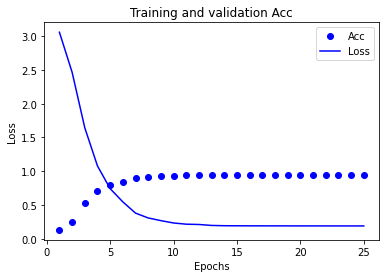

In [55]:
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Acc')
# b is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 14. An End-To-End Classification Model

Pay attention that the above model is expected to receive batches of integer tensors as input:

```
 Layer (type)                Output Shape              Param #   
=================================================================
 input_3 (InputLayer)        [(None, 50)]              0         
```
Thus, you can NOT supply raw data (some text) to the model for prediction. TensorFlow/Keras would generate error message as below:



However, sometimes it a big advantage if we can design a model which accepts raw data as input, then, process the data by itself.

For example such a model can be easily exported different platforms/environments without the need of exporting the preprocess code!

Therefore, Keras provides [several Preprocessing Layers](https://keras.io/api/layers/preprocessing_layers/) so that we can integrate preprocessing logic as a layer into a Keras model.

After then, we can export such models and use any other platforms without re-writing preprocessing code on the exported platforms/environments.

This kind of models can be called **End-To-End Models**. That is, an **End-To-End model** can accept Raw Input Data and preprocess it by itself.

**What could be Raw Data? **

It could be:
* text
* image
* structure data
* etc.

Let's create an **End-To-End Classification Model** by integrating the **adapted** Keras `TextVectorization` layer into the **trained model** as **the first layer**. 

You can create an **End-To-End Model** either by:
* Keras Sequential API, or
* Keras Functional API 

## 14.1. Create an End-To-End Model with Keras Sequential API

In [56]:
opt = keras.optimizers.Adam(learning_rate=0.01)

In [58]:
end_to_end_model = tf.keras.Sequential([
  keras.Input(shape=(1,), dtype="string"),
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

end_to_end_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
end_to_end_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 sequential_1 (Sequential)   (None, 33)                396449    
                                                                 
 activation_1 (Activation)   (None, 33)                0         
                                                                 
Total params: 396,449
Trainable params: 396,449
Non-trainable params: 0
_________________________________________________________________


## 14.3. Test the End-to-End model with Raw (Text) Data

In [65]:
raw_data=['I extremely angry and sad in my relationships. I am hurting friendships. How I fix underlying issues?']
predictions=end_to_end_model.predict(raw_data)
print(id_to_topics[np.argmax(predictions[0])])

Anger Management


In [66]:
predictions

array([[0.02880604, 0.02880604, 0.0781505 , 0.02880604, 0.02880663,
        0.02880604, 0.02880604, 0.0288061 , 0.02880695, 0.02880604,
        0.0288127 , 0.02880608, 0.02880604, 0.02880604, 0.02880606,
        0.02880715, 0.02880605, 0.02880605, 0.02880604, 0.02880605,
        0.02880604, 0.02880605, 0.02880817, 0.02880605, 0.02880604,
        0.02880604, 0.02880604, 0.02883784, 0.02880604, 0.02880613,
        0.02880633, 0.02881851, 0.02880604]], dtype=float32)

In [67]:
raw_data=['I am facing some issues with my friends in the college. They dont help me with studies. I am constantly alone. I am worried about my future. I cannot create bond with people. What could be the issue with me?']
predictions=end_to_end_model.predict(raw_data)
print(id_to_topics[np.argmax(predictions[0])])

Trauma


In [68]:
predictions

array([[0.02920806, 0.02920634, 0.02918994, 0.02918994, 0.02918994,
        0.02918994, 0.02918994, 0.02918994, 0.02919044, 0.02918994,
        0.03168174, 0.02918994, 0.02936126, 0.04037186, 0.02918994,
        0.02919067, 0.02918994, 0.02949519, 0.02918994, 0.02918994,
        0.02919054, 0.02918994, 0.02918994, 0.02918994, 0.02918996,
        0.02918994, 0.02919008, 0.02918994, 0.02918995, 0.02944596,
        0.05146669, 0.02920222, 0.02918999]], dtype=float32)

In [69]:
raw_data=['I just gone through abortion. It is hurting me as hell. I do not want to live anymore.']
predictions=end_to_end_model.predict(raw_data)
print(id_to_topics[np.argmax(predictions[0])])

Anxiety


In [70]:
predictions

array([[0.02880667, 0.02880667, 0.02880667, 0.07811753, 0.02881899,
        0.02880667, 0.0288067 , 0.02880667, 0.02882985, 0.02880667,
        0.02880667, 0.02880667, 0.02882581, 0.02880901, 0.02880667,
        0.02880669, 0.02880667, 0.02880693, 0.02880668, 0.02880667,
        0.02880667, 0.02880667, 0.02880672, 0.02881529, 0.0288091 ,
        0.02880667, 0.02880667, 0.02880667, 0.02880667, 0.02880667,
        0.02880674, 0.02880668, 0.02880716]], dtype=float32)

In [71]:
raw_data=['I am very competitive. I am always on the top of the game. But, recently I am facing performance issues. I am constantly worried about my sport. I play good yet, not able to win matches.']
predictions=end_to_end_model.predict(raw_data)
print(id_to_topics[np.argmax(predictions[0])])

Family Conflict


In [72]:
predictions

array([[0.02880432, 0.02880431, 0.02880431, 0.02880432, 0.02880431,
        0.02880431, 0.02880431, 0.02880431, 0.02882068, 0.02880431,
        0.02880431, 0.02880431, 0.07824111, 0.02880452, 0.02880431,
        0.02880431, 0.02880431, 0.02880822, 0.02880431, 0.02880431,
        0.02880444, 0.02880431, 0.02880431, 0.02880456, 0.02880438,
        0.02880431, 0.02880431, 0.02880431, 0.02880431, 0.02880431,
        0.02880435, 0.02880431, 0.02880431]], dtype=float32)

In [73]:
raw_data=['My wife and I fight everyday. Cause could be a small reason. She is having lot of office work. I am not able to spend time with her. How can we solve the problem?']
predictions=end_to_end_model.predict(raw_data)
print(id_to_topics[np.argmax(predictions[0])])

Relationships


In [74]:
predictions

array([[0.0288033 , 0.0288033 , 0.0288033 , 0.0288033 , 0.0288033 ,
        0.0288033 , 0.0288033 , 0.0288033 , 0.0288033 , 0.0288033 ,
        0.0288033 , 0.0288033 , 0.02880334, 0.0288033 , 0.02880334,
        0.0288033 , 0.0288033 , 0.0288033 , 0.02880385, 0.0288033 ,
        0.0288033 , 0.0288033 , 0.0288033 , 0.07829378, 0.0288033 ,
        0.0288033 , 0.0288033 , 0.0288033 , 0.0288033 , 0.0288033 ,
        0.0288033 , 0.0288033 , 0.0288033 ]], dtype=float32)

In [76]:
raw_data=['I went through sexual abuse in my childhood. It is constantly in my head. I cannot forget it. What should I do?']
predictions=end_to_end_model.predict(raw_data)
print(id_to_topics[np.argmax(predictions[0])])

Family Conflict


In [77]:
predictions

array([[0.02888212, 0.02888195, 0.02888195, 0.02888234, 0.02888198,
        0.02888195, 0.02888195, 0.02888195, 0.02888198, 0.02888195,
        0.02888218, 0.02888195, 0.07406063, 0.02888205, 0.02888433,
        0.02888196, 0.02890733, 0.02921734, 0.02888414, 0.02888195,
        0.02888196, 0.02888204, 0.02888195, 0.03022246, 0.02888198,
        0.02888195, 0.02888236, 0.02888195, 0.02888195, 0.02888195,
        0.02888878, 0.02888196, 0.02888469]], dtype=float32)

In [78]:
raw_data=['I have put on lot of weight. I am really embarrassed and shameful to wear big clothes. How can I reduce my thoughts? ']
predictions=end_to_end_model.predict(raw_data)
print(id_to_topics[np.argmax(predictions[0])])

Anxiety


In [79]:
predictions

array([[0.02894841, 0.02894838, 0.0289486 , 0.07035195, 0.02960369,
        0.02894838, 0.02894871, 0.02894838, 0.03033829, 0.02894838,
        0.02894838, 0.02894838, 0.02895544, 0.02894984, 0.02894841,
        0.02902098, 0.02894839, 0.0289488 , 0.02894933, 0.02894913,
        0.02894838, 0.02894838, 0.02906435, 0.02898319, 0.02996771,
        0.02894838, 0.02894845, 0.02894838, 0.02894838, 0.0289484 ,
        0.02894857, 0.02894863, 0.02894855]], dtype=float32)

In [81]:
loss, accuracy = end_to_end_model.evaluate(test_features,test_targets)
print("end_to_end_model accuracy: ", accuracy)

10/10 [==============================] - 4s 23ms/step - loss: 2.8416 - accuracy: 0.7104
end_to_end_model accuracy:  0.7104377150535583


## 14.4. Save the End-to-End model

In [83]:
end_to_end_model.save("end_to_end_model")

INFO:tensorflow:Assets written to: end_to_end_model/assets


INFO:tensorflow:Assets written to: end_to_end_model/assets


## 14.5. Load the End-to-End model

In [84]:
loaded_end_to_end_model = tf.keras.models.load_model("end_to_end_model")

## 14.6. Test the Loaded End-to-End model with Raw (Text) Data

In [85]:
loss, accuracy = loaded_end_to_end_model.evaluate(test_features,test_targets)
print("loaded_end_to_end_model accuracy: ", accuracy)

10/10 [==============================] - 2s 28ms/step - loss: 2.8416 - accuracy: 0.7104
loaded_end_to_end_model accuracy:  0.7104377150535583


# **SUMMARY**
WHAT WE HAVE WORKED ON ABOVE
* What a Keras `TextVectorization` layer is
* Why we need to use a Keras `TextVectorization` layer in Natural Languge Processing (NLP) tasks
* How to employ a Keras `TextVectorization` layer in Text Preprocessing
* How to integrate a Keras `TextVectorization` layer to a trained model
* How to save and upload a Keras `TextVectorization` layer and a model with a Keras `TextVectorization` layer
* How to integrate a Keras `TextVectorization` layer with TensorFlow Data Pipeline API (`tf.data`)
* How to design, train, save, and load an End-to-End model using Keras `TextVectorization` layer

All above topics are presented in a **multi-class text classification** context.